In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['0', '1', '2']
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
MODEL_NAME = "XGB_apart_old"

In [5]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [8]:
GANS_NAME = 'GAN_Kramer_dim3_bs1e4_n80-150_old_pid'
data_test_pid_a = np.array(pd.read_csv('./data/AE_GAN_TEST_{}{}.csv'.format(GANS_NAME, 'a')))
data_test_pid_b = np.array(pd.read_csv('./data/AE_GAN_TEST_{}{}.csv'.format(GANS_NAME, 'b')))
data_test_pid_c = np.array(pd.read_csv('./data/AE_GAN_TEST_{}{}.csv'.format(GANS_NAME, 'c')))
data_test_pid_d = np.array(pd.read_csv('./data/AE_GAN_TEST_{}{}.csv'.format(GANS_NAME, 'd')))
data_test_pid_e = np.array(pd.read_csv('./data/AE_GAN_TEST_{}{}.csv'.format(GANS_NAME, 'e')))
data_test_pid_f = np.array(pd.read_csv('./data/AE_GAN_TEST_{}{}.csv'.format(GANS_NAME, 'f')))

data_test = np.concatenate([data_test_pid_a, data_test_pid_b, data_test_pid_c, data_test_pid_d, data_test_pid_e, data_test_pid_f], axis=0)
data_test = pd.DataFrame(data_test, columns=out_columns+in_columns+["pid"])
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,0.468389,0.0946346,-0.429496,-0.478481,-1.13167,0,0,0,a
1,0.503322,0.098731,-0.497637,0.169346,0.698694,0,0,0,a
2,-0.0180916,0.380685,-0.411201,-0.234269,0.0638002,0,0,0,a
3,0.111733,-0.212977,0.809453,-0.372792,-0.598165,-1000,-1000,0,a
4,0.172562,-0.16539,0.80245,-0.422047,-0.337751,-1000,-1000,0,a


In [9]:
np.unique(data_test["pid"], return_counts=True)

(array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object),
 array([16361, 16361, 16362, 16362, 16361, 16362]))

In [16]:
aux = pd.read_csv("./data/aux_test_old.csv")
aux.head()

,Unnamed: 0,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,pid
0,0,-1.000000,0.223544,0.259309,-0.169944,-0.060651,0.060418,-0.196945,0.259122,0.259099,0.25913,0.177146,0.0,0.180869,-0.000066,-0.000413,3
1,1,0.284772,-1.000000,-1.000000,-0.079052,-0.272781,0.048958,-0.130448,-1.000000,-1.000000,-1.00000,0.693089,0.0,-0.071268,-0.000446,-0.000462,3
2,2,0.284772,0.223544,0.259309,0.218310,0.151479,0.265819,0.069043,0.259122,0.259099,0.25913,0.193540,0.0,0.015368,0.000019,-0.000003,1
3,3,0.284772,0.223544,0.259309,0.210698,0.080769,-0.098238,-0.329938,0.259122,0.259099,0.25913,0.659901,0.0,0.113064,-0.000271,-0.000453,3
4,4,0.284772,0.223544,0.259309,0.289215,-0.060651,0.257866,0.069043,0.259122,0.259099,0.25913,0.803982,0.0,0.022962,0.001097,0.001137,3


In [17]:
data_pid_aux = {}

for pid in range(6):
    data_pid_aux[pid] = aux[aux.pid == pid]

In [18]:
for column in aux.columns:
    if "aux" in column:
        data_test[column] = np.concatenate([data_pid_aux[pid][column].values for pid in range(6)])

In [19]:
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux8
0,0.468389,0.0946346,-0.429496,-0.000425,-0.261844,0.223544,0.259309,0.284772,a,-0.023609,0.151479,-0.100290,-0.130448,0.259122,0.259099,0.25913,-0.330167,0.0,-0.000056
1,0.503322,0.098731,-0.497637,-0.000153,0.142402,0.223544,0.259309,0.284772,a,-0.110724,0.080769,-0.044189,-0.063951,0.259122,0.259099,0.25913,-0.466117,0.0,-0.000412
2,-0.0180916,0.380685,-0.411201,-0.000322,0.002182,0.223544,0.259309,0.284772,a,-0.184076,-0.697042,0.073549,0.534522,0.259122,0.259099,0.25913,-0.326070,0.0,-0.000368
3,0.111733,-0.212977,0.809453,-0.000380,-0.144016,-1.000000,-1.000000,0.284772,a,0.065298,0.363609,0.191085,0.069043,-1.000000,-1.000000,-1.00000,-0.058140,0.0,-0.000207
4,0.172562,-0.16539,0.80245,-0.000401,-0.086502,-1.000000,-1.000000,0.284772,a,0.087397,-0.060651,0.120089,0.135540,-1.000000,-1.000000,-1.00000,0.050400,0.0,-0.000360


In [20]:
aux_columns = ['S5aux0',
 'S3aux0',
 'S2aux0',
 'S0aux0',
 'S0aux1',
 'S0aux2',
 'S0aux3',
 'S2aux1',
 'S2aux2',
 'S2aux3',
 'S0aux4',
 'S0aux5',
 'S0aux6',
 'S0aux7',
 'S0aux8']

In [21]:
data_test_enc = data_test[out_columns]
data_test_aux = data_test[aux_columns]

## Decoding using Autoencoder

In [22]:
def create_autoencoder_aux(n_features, encoding_dim, n_aux_features=5, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
        x = keras.layers.concatenate([x, aux_inputs])

    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    x = keras.layers.concatenate([x, aux_inputs])
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    
    for i in range(n_layers - 1):
        x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )

    optimizer_adam = optimizers.Adam(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

In [23]:
autoencoder, encoder, decoder = create_autoencoder_aux(
        35, 3, 
        n_aux_features=15, n_layers=4, thickness=6
    )

In [25]:
autoencoder.load_weights("./models/model_old_ratio10_{}.hdf5".format(3))

In [26]:
decoded_test = decoder.predict([data_test_enc, data_test_aux])

In [27]:
vars_list_input = ['S0x0','S0x1','S0x2','S0x3','S0x4','S3x0','S3x1','S2x0','S2x1','S2x2','S2x3','S0x5','S0x6',
 'S0x7','S0x8','S0x9','S0x10','S1x0','S1x1','S1x2','S1x3','S1x4','S1x5','S5x0','S4x0','S4x1','S4x2','S3x2','S4x3',
 'S4x4','S5x1','S5x2','S5x3','S5x4','S4x5']

In [28]:
scalers = {var: {} for var in vars_list_input}
for i, var in enumerate(vars_list_input):
    scalers[var]['std'] = joblib.load(os.path.join('./preprocessors', "scaler_std_"+var) + ".pkl")
    scalers[var]['max'] = joblib.load(os.path.join('./preprocessors', "scaler_max_"+var) + ".pkl")

In [29]:
decoded_unscaled = decoded_test.copy()
for i, var in enumerate(vars_list_input):
    decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(decoded_unscaled[:, i].reshape(-1, 1))
    ).reshape(-1)

In [37]:
le = LabelEncoder()
y_ = le.fit_transform(data_test["pid"].values)

In [38]:
X = decoded_unscaled
Y = y_

## XGBoost for PID Classification

#### original data

In [52]:
xgb_test = pd.read_csv('./data/orig_test_old.csv')

In [59]:
X_test_orig = xgb_test.drop(["Unnamed: 0", "pid"], axis=1)[vars_list_input].values
Y_test_orig = xgb_test["pid"].values

#### data after AE

In [35]:
X_test_ae = pd.read_csv('./data/ae_test_pid_{}_old.csv'.format(3))
Y_test_ae = X_test_ae["pid"].values
X_test_ae = X_test_ae[vars_list_input].values

-------------

In [36]:
from helpers import *

In [41]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [43]:
clf_name = "XGBoost_old_{}".format(9)
clf = xgb.XGBClassifier(nthread=-1, seed=111)
clf = joblib.load(os.path.join('./xgboost', clf_name) + ".pkl")

In [40]:
path_to_metrics = './metrics/'
metrics_dir_name = "GAN_XGB_old"

In [39]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

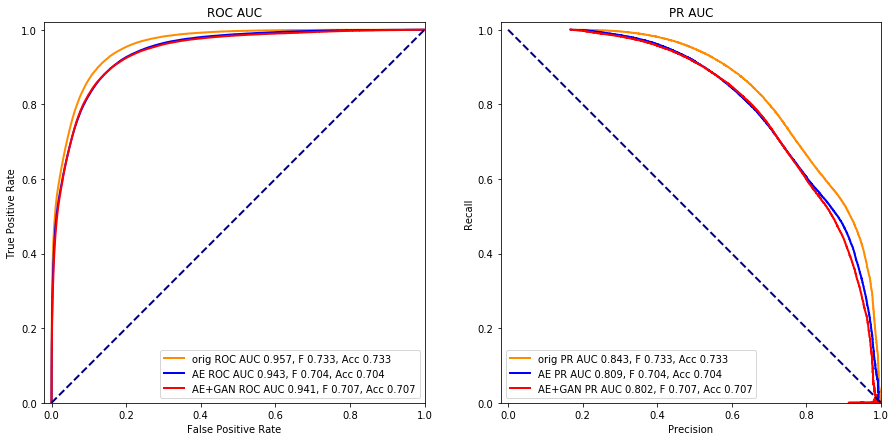

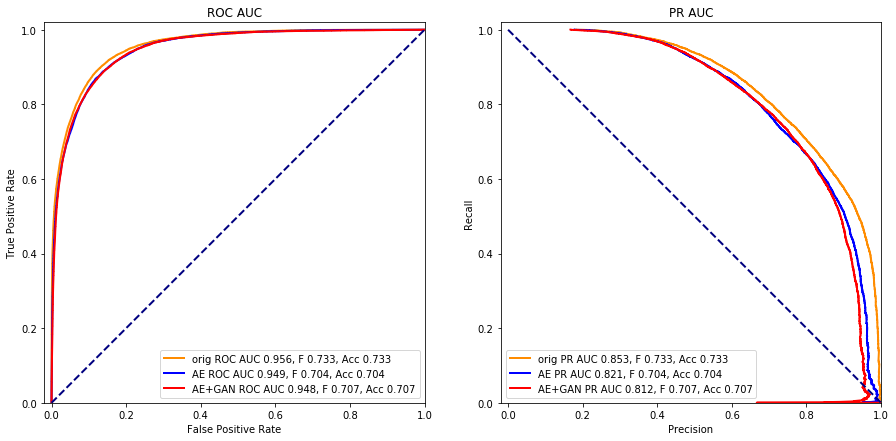

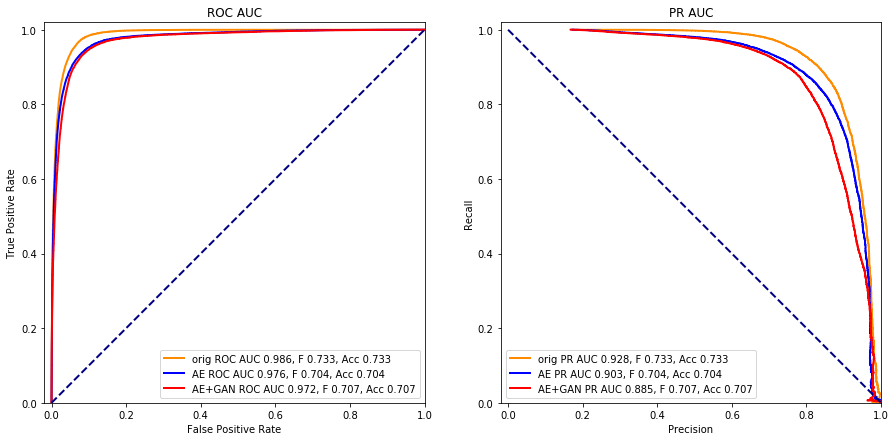

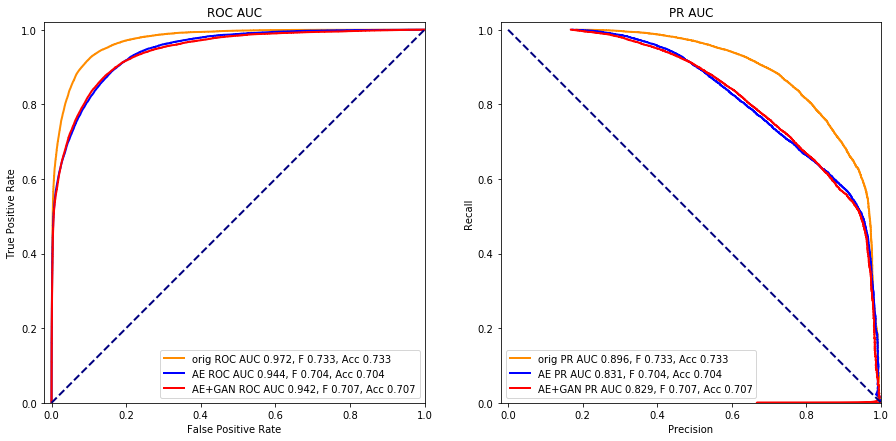

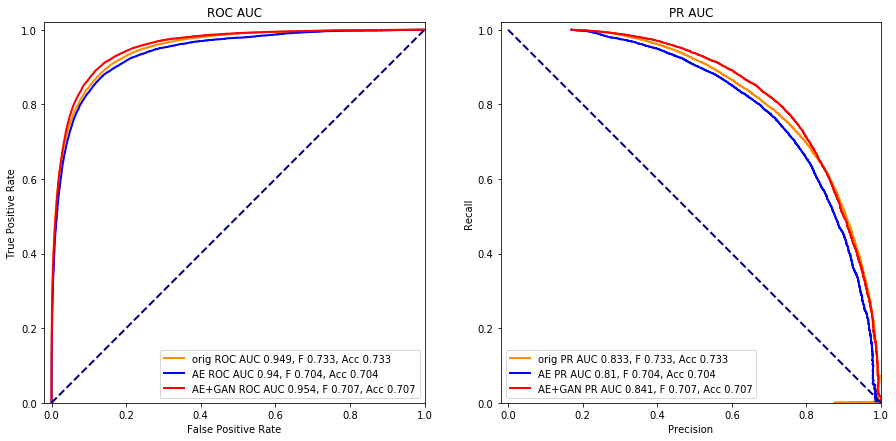

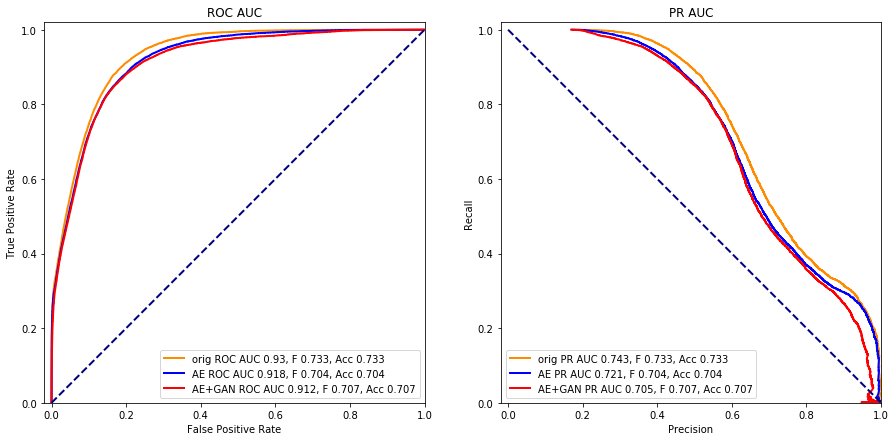

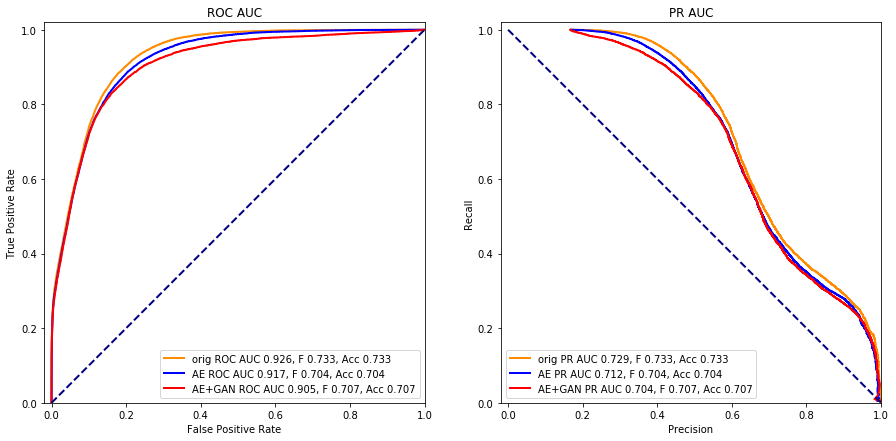

100%|██████████| 3/3 [01:11<00:00, 23.88s/it]


In [62]:
from tqdm import tqdm
for encoding_dim in tqdm(["orig", "AE", "AE+GAN"]):
    if encoding_dim == "orig":
        y_proba = clf.predict_proba(X_test_orig)
        y = Y_test_orig
    elif encoding_dim == "AE":
        y_proba = clf.predict_proba(X_test_ae)
        y = Y_test_ae
    else:
        y_proba = clf.predict_proba(X)
        y = Y
        
    y_bin = label_binarize(y, classes=np.unique(y))
    y_pred = np.argmax(y_proba, axis=1)
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y):
        idx = np.where(y == pid_label)[0]
        cur_y = np.where(y == pid_label, np.ones_like(y), np.zeros_like(y))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
        metrics_dict['roc_auc'][encoding_dim][pid_label] = auc(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label])
        metrics_dict['pr_auc'][encoding_dim][pid_label] = average_precision_score(cur_y.ravel(), cur_y_proba.ravel())
        
#         metrics_dict['f_measure'][encoding_dim][pid_label] = f1_score(y, y_pred, average='micro')
#         metrics_dict['acc'][encoding_dim][pid_label] = accuracy_score(y, y_pred)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='0', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='1', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='2', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='3', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='4', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='5', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
#     plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))